In [1]:
%reload_ext autoreload
%autoreload 2

from offline_playback import process_stroke, replay_data, merge_data, get_black_points, normalize_points
import numpy as np
from PIL import Image
import pickle
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
import seaborn as sns

from offline_playback import ProcessedStroke

%matplotlib inline

recording_timestamp = "20230905_162344"
savefig_kwargs = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0}

scan_img = Image.open(f"./recordings/{recording_timestamp}/scan.jpg")
scan_dpi, _ = scan_img.info.get("dpi")
scan_x, scan_y = get_black_points(np.asarray(scan_img), scan_dpi)
scan_points = normalize_points(np.column_stack((scan_x, scan_y)))

def load_and_process(stylus_data_fname, camera_data_fname, smoothing_length=14, imu_skip=1, camera_skip=1):
    with open(
        f"./recordings/{recording_timestamp}/{stylus_data_fname}", "rb"
    ) as pickle_file:
        stylus_data = pickle.load(pickle_file)
    with open(
        f"./recordings/{recording_timestamp}/{camera_data_fname}", "rb"
    ) as pickle_file:
        camera_data = pickle.load(pickle_file)
    recorded_data = merge_data(stylus_data[1::imu_skip], camera_data[::camera_skip])
    tip_pos_predicted, tip_pos_smoothed, pressure = replay_data(
        recorded_data,
        dt=imu_skip/120,
        smoothing_length=smoothing_length,
        camera_delay=4//imu_skip,
    )
    tpp = process_stroke(tip_pos_predicted, scan_points, pressure)
    tps = process_stroke(tip_pos_smoothed, scan_points, pressure)
    return tpp, tps

def stroke_to_linecollection(stroke: ProcessedStroke, width, color):
    xy = stroke.position * 1000
    x, y = xy[:, 0], xy[:, 1]
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    lc = LineCollection(segments)
    pressure_clip = np.clip(stroke.pressure, 0, 1)
    lc.set_linewidth((pressure_clip**0.7) * width)
    # alpha = np.sqrt(pressure_clip)[:,np.newaxis]
    # color_vec = np.array(color,  dtype=float) * alpha + (1 - alpha)
    lc.set_alpha(pressure_clip**0.3)
    lc.set_color(color)
    lc.set_rasterized(True)
    lc.set_capstyle("round")
    proxy = Line2D([0, 1], [0, 1], color=color, lw=width, solid_capstyle="round")
    return lc, proxy

def plot_scan_points(scan_points, ax=None):
    ax: Axes = sns.scatterplot(
        x=scan_points[:, 0] * 1000,
        y=scan_points[:, 1] * 1000,
        color=(0.8, 0.8, 1),
        s=5,
        alpha=0.6,
        linewidth=0,
        ax=ax,
    )
    ax.set_aspect("equal")
    ax.set(xlabel="x (mm)", ylabel="y (mm)", ylim=(-48,34))
    ax.collections[0].set_rasterized(True)
    return ax

def plot_strokes(ax, tpp, tps):
    lc1, lc1_proxy = stroke_to_linecollection(tpp, 1.5, color=(0.9, 0.6, 0.6))
    ax.add_collection(lc1)
    lc2, lc2_proxy = stroke_to_linecollection(tps, 2.3, color=(0, 0, 0))
    ax.add_collection(lc2)
    ax.legend(
        [ax.collections[0], lc1_proxy, lc2_proxy],
        [
            "Scan",
            f"Predicted stroke, before smoothing (d={tpp.dist_mean*1000:0.3f}mm)",
            f"Estimated stroke, after smoothing (d={tps.dist_mean*1000:0.3f}mm)",
        ],
        loc="lower left",
        markerscale=3,
    )

def mini_plot(tpp, tps, noleftlabels=False, ax=None):
    ax = plot_scan_points(scan_points, ax=ax)
    plot_strokes(ax, tpp, tps)
    ax.set(ylim=(-62, 34))
    if noleftlabels:
        ax.set(ylabel=None, yticklabels=[])
    return ax

## Main sketch plot

sample_count: 4627
Resetting state, errors: 0.28229554569920684, 1.1370123937020913


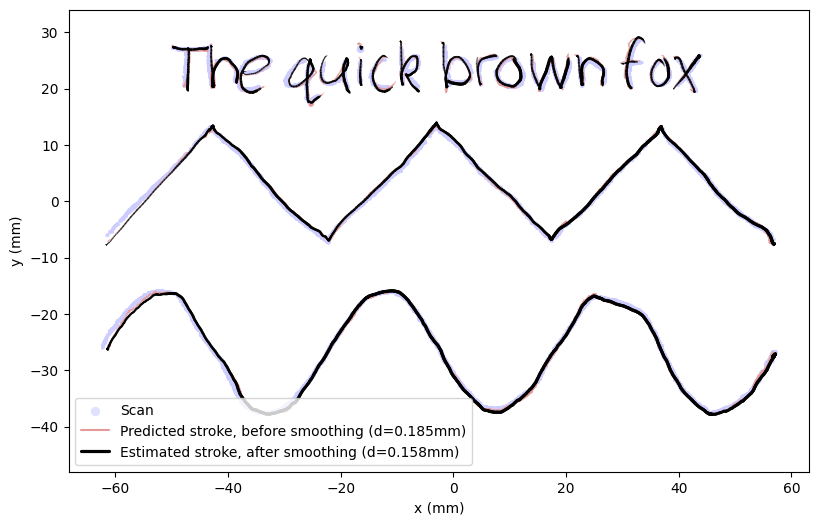

In [48]:
proposed_tpp, proposed_tps = load_and_process("stylus_data.pkl", "camera_data.pkl")
fig = plt.figure()
fig.set_size_inches(100,6)
ax = plot_scan_points(scan_points)
plot_strokes(ax, proposed_tpp, proposed_tps)

# plt.savefig(f"./recordings/{recording_timestamp}/main-sketch-plot.pdf", **savefig_kwargs)

## Feature comparisons

In [3]:
nomarkercalib = load_and_process("stylus_data.pkl", "camera_data_nomarkercalib.pkl")
norsc = load_and_process("stylus_data.pkl", "camera_data_norsc.pkl")
epnp = load_and_process("stylus_data.pkl", "camera_data_epnp.pkl")
sqpnp = load_and_process("stylus_data.pkl", "camera_data_sqpnp.pkl")

sample_count: 4627
Resetting state, errors: 0.28199730820000646, 1.1368225296179302
sample_count: 4627
Resetting state, errors: 0.2823078918282777, 1.1369417631891388
sample_count: 4627
Resetting state, errors: 0.28238099756360474, 1.137549297581487
sample_count: 4627
Resetting state, errors: 0.28240014234383687, 1.1354962479796713


<Axes: xlabel='x (mm)'>

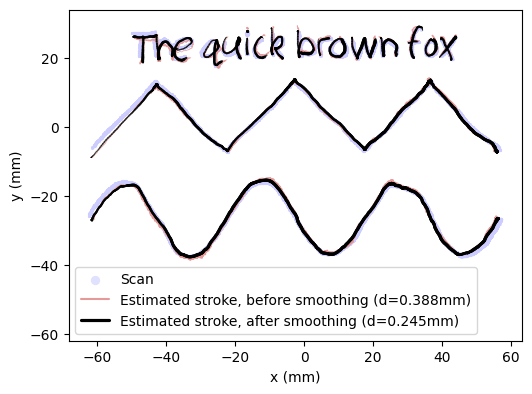

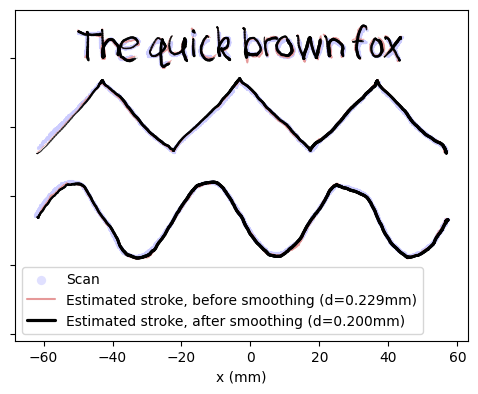

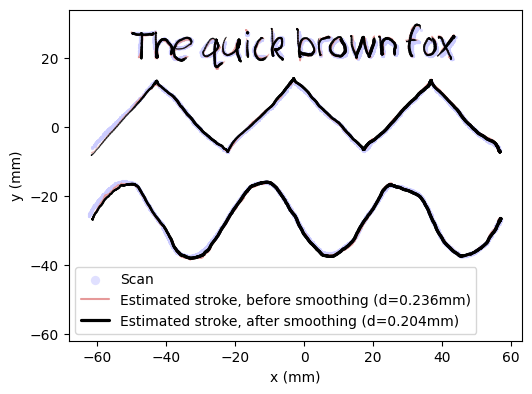

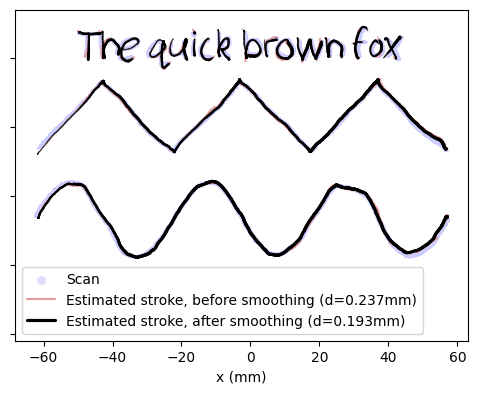

In [4]:
%matplotlib inline

fig = plt.figure(figsize=(100,4.3))
mini_plot(*nomarkercalib)
# plt.savefig(f"./recordings/{recording_timestamp}/nomarkercalib.pdf", **savefig_kwargs)

fig = plt.figure(figsize=(100,4.3))
mini_plot(*norsc, noleftlabels=True)
# plt.savefig(f"./recordings/{recording_timestamp}/norsc.pdf", **savefig_kwargs)

fig = plt.figure(figsize=(100,4.3))
mini_plot(*epnp)
# plt.savefig(f"./recordings/{recording_timestamp}/epnp.pdf", **savefig_kwargs)

fig = plt.figure(figsize=(100,4.3))
mini_plot(*sqpnp, noleftlabels=True)
# plt.savefig(f"./recordings/{recording_timestamp}/sqpnp.pdf", **savefig_kwargs)

## Smoothing

In [18]:
smoothing_lens = [0, 10, 50, 500]
smoothing_results = [
  load_and_process("stylus_data.pkl", "camera_data.pkl", smoothing_length=sl)
  for sl in smoothing_lens
]

sample_count: 4627
Resetting state, errors: 0.28229554569920684, 1.1370123937020913
sample_count: 4627
Resetting state, errors: 0.28229554569920684, 1.1370123937020913
sample_count: 4627
Resetting state, errors: 0.28229554569920684, 1.1370123937020913
sample_count: 4627
Resetting state, errors: 0.28229554569920684, 1.1370123937020913


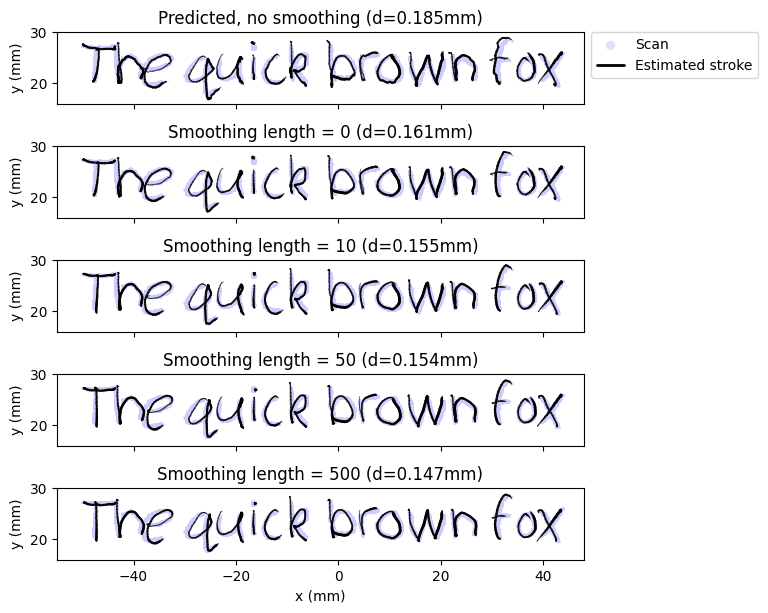

In [19]:
fig, axs = plt.subplots(len(smoothing_lens) + 1, 1, figsize=(6, 6), sharex=True)
fig.tight_layout()
lc_predicted, lc_proxy_predicted = stroke_to_linecollection(smoothing_results[0][0], 2, color=(0, 0, 0))
plot_scan_points(scan_points, ax=axs[0])
axs[0].add_collection(lc_predicted)
axs[0].set(xlim=(-55,48), ylim=(16, 30))
axs[0].set_title(f"Predicted, no smoothing (d={smoothing_results[0][0].dist_mean*1000:0.3f}mm)")
for i, sr in enumerate(smoothing_results):
    ax: Axes = axs[i+1]
    plot_scan_points(scan_points, ax=ax)
    # plot_strokes(ax, sr[0], sr[1], legend=False)
    lc, lc_proxy = stroke_to_linecollection(sr[1], 2, color=(0, 0, 0))
    ax.add_collection(lc)
    ax.set(xlim=(-55,48), ylim=(16, 30))
    ax.set_title(f"Smoothing length = {smoothing_lens[i]} (d={sr[1].dist_mean*1000:0.3f}mm)")

fig.legend(
    [axs[0].collections[0], lc_proxy_predicted],
    [
        "Scan",
        "Estimated stroke",
    ],
    # loc=(0.74, 0.89),
    loc='upper left',
    bbox_to_anchor=(1, 1.1),
    bbox_transform=axs[0].transAxes,
    markerscale=3,
)
plt.savefig(f"./recordings/{recording_timestamp}/smoothing-comparison.pdf", **savefig_kwargs)

## Camera frame rate

In [2]:
camera_skips = list(range(1, 11))
camera_skip_results = [
    load_and_process("stylus_data.pkl", "camera_data.pkl", camera_skip=cs, smoothing_length=10)
    for cs in camera_skips
]

sample_count: 4627
Resetting state, errors: 0.28229554569920684, 1.1370123937020913
sample_count: 4627
Resetting state, errors: 0.2812211185093062, 1.137077470003617
sample_count: 4627
Resetting state, errors: 0.27874033174241386, 1.1371696637981201
sample_count: 4627
Resetting state, errors: 0.2639346551828508, 1.1376029345592118
sample_count: 4627
Resetting state, errors: 0.2537319774689035, 1.1380023615860735
sample_count: 4627
Resetting state, errors: 0.23994241788320975, 1.1385360043003525
sample_count: 4627
Resetting state, errors: 0.23213673396645487, 1.1384872628339664
sample_count: 4627
Resetting state, errors: 0.23228648008216804, 1.13887935932876
sample_count: 4627
Resetting state, errors: 0.24500974670494582, 1.139031593443575
sample_count: 4627
Resetting state, errors: 0.2804328707927671, 1.1392517674822875


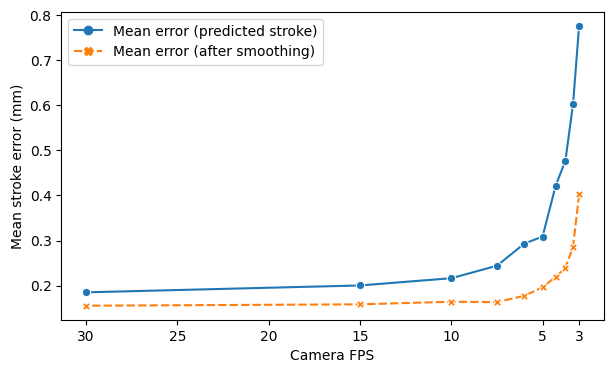

In [5]:
import pandas as pd
camera_skip_df = pd.DataFrame(
    {
        "camera_skip": camera_skips,
        "fps": [30/cs for cs in camera_skips],
        "Mean error (predicted stroke)": [sr[0].dist_mean*1000 for sr in camera_skip_results],
        "Mean error (after smoothing)": [sr[1].dist_mean*1000 for sr in camera_skip_results],
    }
)

fig = plt.figure(figsize=(7, 4))
ax: Axes = sns.lineplot(
    x="fps",
    y="value",
    style="variable",
    hue="variable",
    markers=True,
    data=pd.melt(camera_skip_df, ["camera_skip", "fps"]),
    legend="brief",
)

ax.set(xticks=list(range(30, 0, -5)) + [3])
ax.set(xlabel="Camera FPS", ylabel="Mean stroke error (mm)")
ax.invert_xaxis()
ax.get_legend().set_title(None)
# plt.savefig(f"./recordings/{recording_timestamp}/error-vs-camera-fps.pdf", **savefig_kwargs)

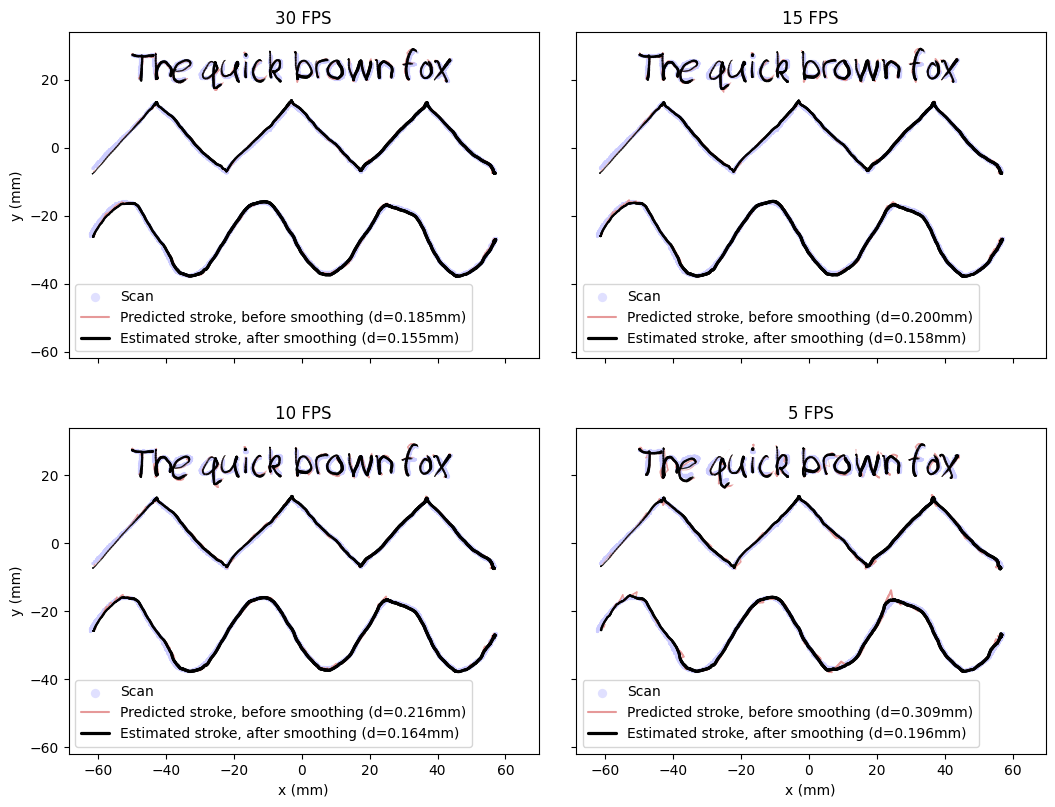

In [142]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.5, 8.5))
# plt.subplot()
fig.tight_layout()
fig.subplots_adjust(hspace=0)
for i in range(4):
    j = [0, 1, 2, 5][i]
    ax = mini_plot(*camera_skip_results[j], ax=axs.flat[i])
    ax.set_title(f"{30/camera_skips[j]:.0f} FPS")

def get_camera_points(stroke: ProcessedStroke):
    pos = stroke.position[stroke.pressure > 0.05,:]
    xy = pos[::120//30,:] * 1000
    x, y = xy[:, 0], xy[:, 1]
    return x, y
# ax.scatter(*get_camera_points(camera_skip_results[3][1]), s=6, marker='.', zorder=10)
# plt.savefig(f"./recordings/{recording_timestamp}/camera-fps-comparison.pdf", **savefig_kwargs)